In [ ]:
# 02 – Data Preparation

This notebook focuses on cleaning the dataset, handling missing values, encoding categorical variables, and preparing the data in a format suitable for machine learning models.


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from core.data import load_from_kaggle


c:\Users\Admin\Git\loan-default-prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../data/raw/loan-default-dataset/loan_default.csv")

In [3]:
pairplot_vars = [
    'loan_amount',
    'LTV',
    'dtir1',
    'income',
    'property_value',
    'Credit_Score'
]


In [4]:
# detecting outliers with 1.5 MAD
def mad(series):
    median = np.median(series)
    return np.median(np.abs(series - median))

In [5]:
def mad_outliers(series, thresh=1.5):
    median = np.median(series)
    mad_val = mad(series)
    
    if mad_val == 0:
        return np.zeros(len(series), dtype=bool)
    
    return np.abs(series - median) > thresh * mad_val


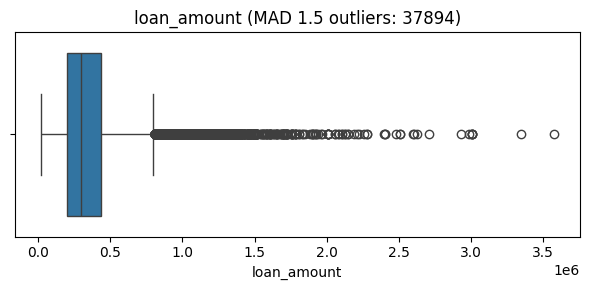

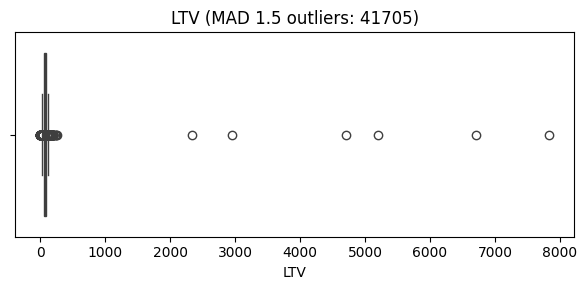

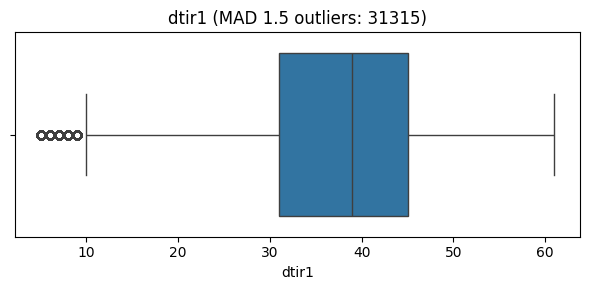

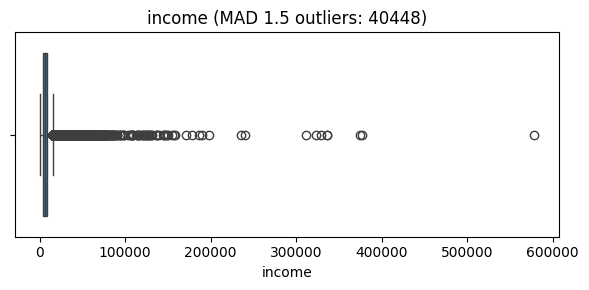

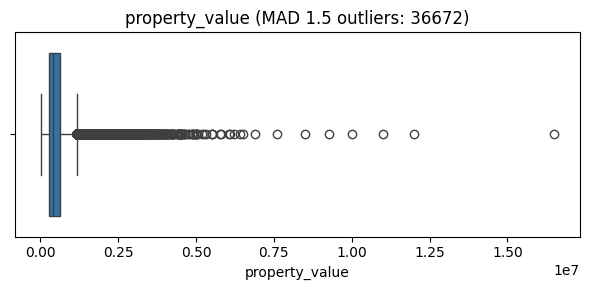

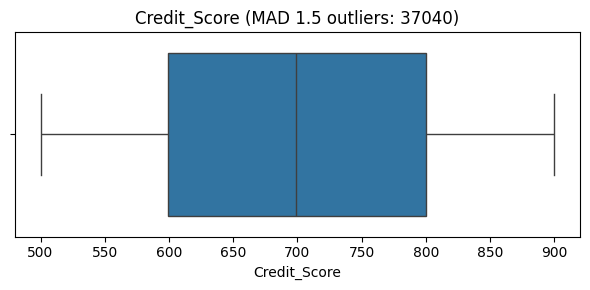

In [6]:

outlier_summary = []

for col in pairplot_vars:
    series = df[col].dropna()
    
    # MAD-based outliers
    is_outlier = mad_outliers(series)
    outlier_count = is_outlier.sum()
    
    outlier_summary.append({
        'feature': col,
        'n_outliers_mad_1.5': outlier_count,
        'outlier_percentage': round(outlier_count / len(series) * 100, 2)
    })
    
    # Boxplot
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=series, orient='h')
    plt.title(f'{col} (MAD 1.5 outliers: {outlier_count})')
    plt.tight_layout()
    plt.show()


In [7]:
outlier_summary_df = pd.DataFrame(outlier_summary)
outlier_summary_df


,feature,n_outliers_mad_1.5,outlier_percentage
0,loan_amount,37894,25.49
1,LTV,41705,31.22
2,dtir1,31315,25.14
3,income,40448,28.99
4,property_value,36672,27.45
5,Credit_Score,37040,24.91


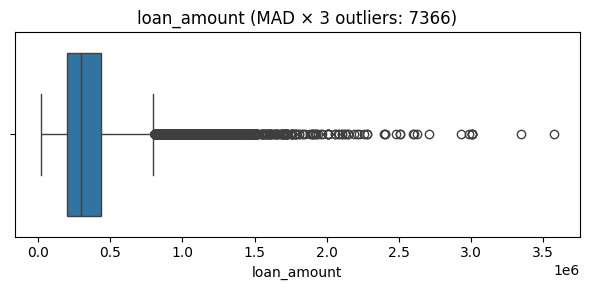

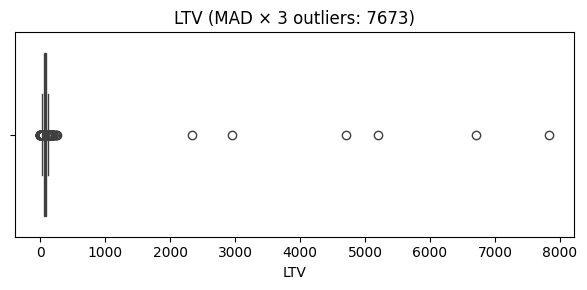

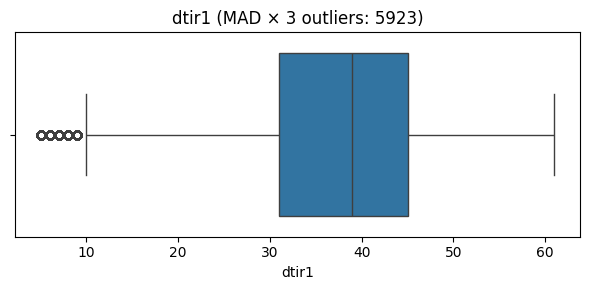

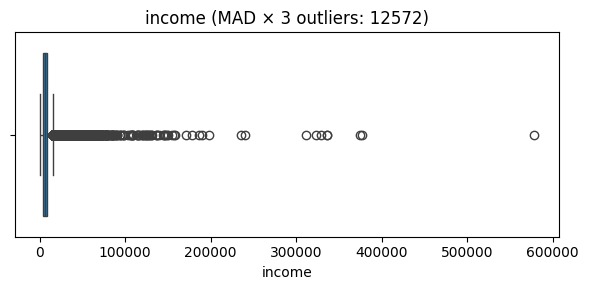

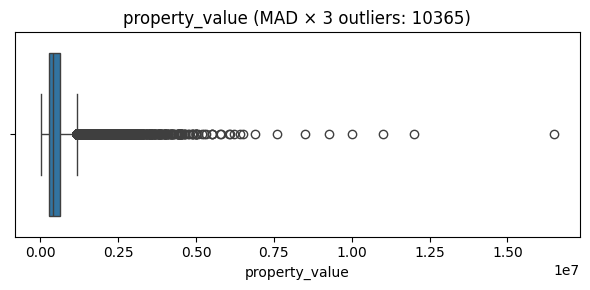

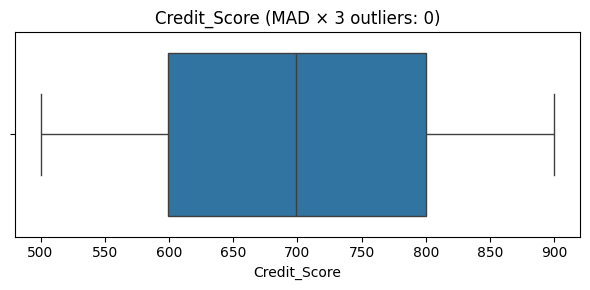

In [8]:
# detecting outliers with 3 MAD

outlier_summary = []

for col in pairplot_vars:
    series = df[col].dropna()

    is_outlier = mad_outliers(series, thresh=3)
    outlier_count = is_outlier.sum()

    outlier_summary.append({
        'feature': col,
        'n_outliers_mad_3': outlier_count,
        'outlier_percentage': round(outlier_count / len(series) * 100, 2)
    })

    plt.figure(figsize=(6, 3))
    sns.boxplot(x=series, orient='h')
    plt.title(f'{col} (MAD × 3 outliers: {outlier_count})')
    plt.tight_layout()
    plt.show()
    

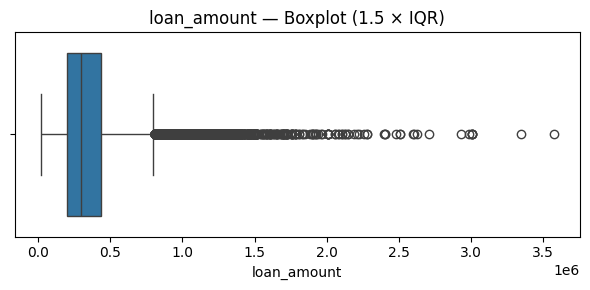

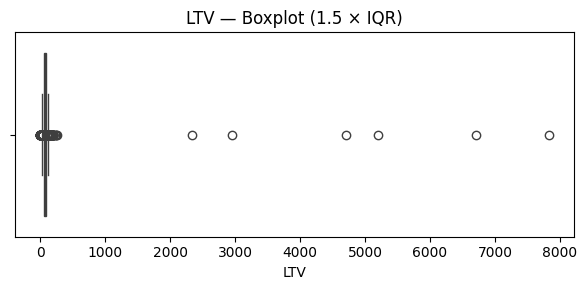

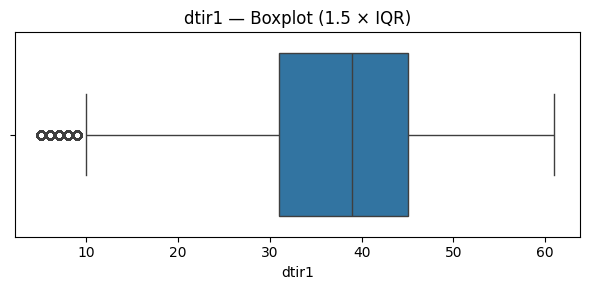

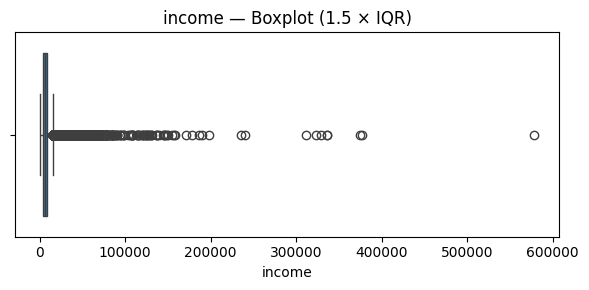

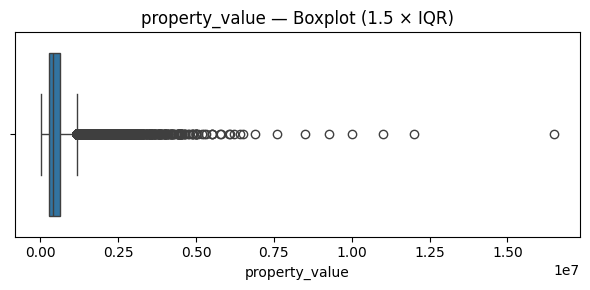

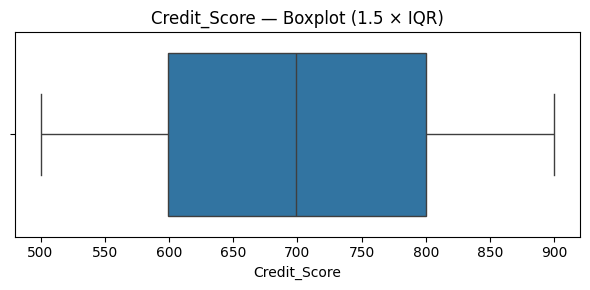

In [9]:
#detecting outliers with IQR
import matplotlib.pyplot as plt
import seaborn as sns

for col in pairplot_vars:
    plt.figure(figsize=(6, 3))
    sns.boxplot(
        x=df[col],
        showfliers=True   # default, explicit for clarity
    )
    plt.title(f'{col} — Boxplot (1.5 × IQR)')
    plt.tight_layout()
    plt.show()


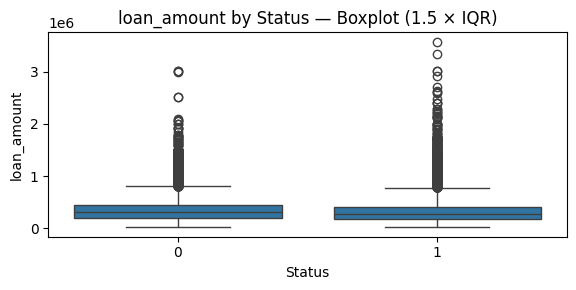

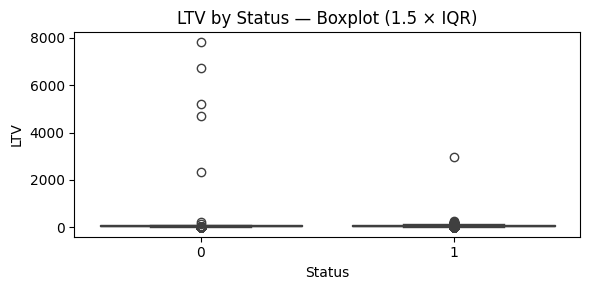

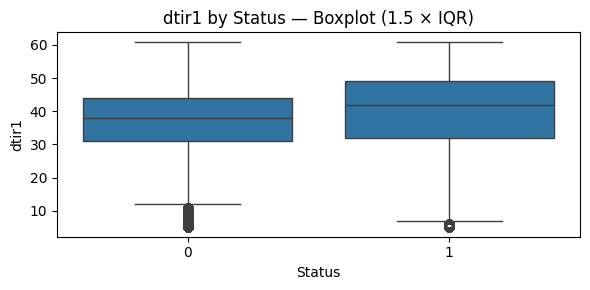

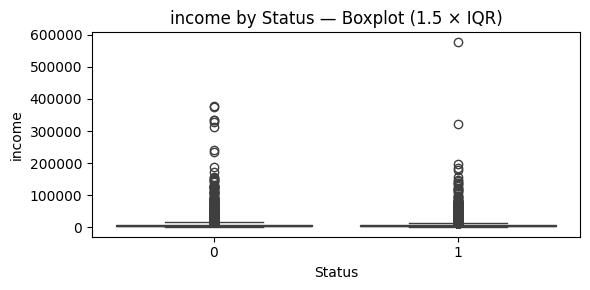

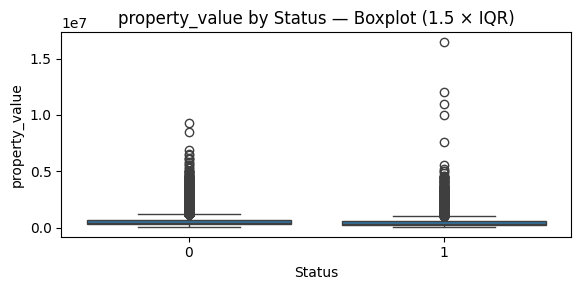

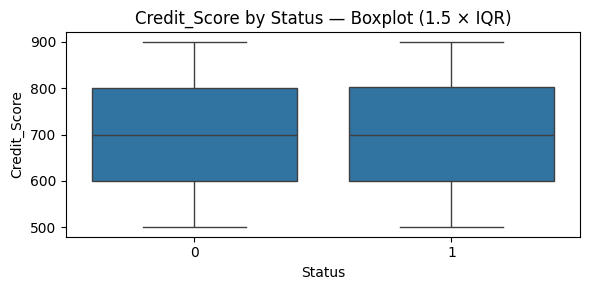

In [10]:
# boxplots by target 
for col in pairplot_vars:
    plt.figure(figsize=(6, 3))
    sns.boxplot(
        data=df,
        x='Status',
        y=col,
        showfliers=True
    )
    plt.title(f'{col} by Status — Boxplot (1.5 × IQR)')
    plt.tight_layout()
    plt.show()

In [11]:
iqr_outlier_summary = []

for col in pairplot_vars:
    series = df[col].dropna()

    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    n_outliers = ((series < lower) | (series > upper)).sum()

    iqr_outlier_summary.append({
        'feature': col,
        'n_outliers_iqr_1.5': n_outliers,
        'outlier_percentage': round(n_outliers / len(series) * 100, 2),
        'lower_bound': round(lower, 2),
        'upper_bound': round(upper, 2)
    })


In [12]:
iqr_outlier_df = pd.DataFrame(iqr_outlier_summary)
iqr_outlier_df


,feature,n_outliers_iqr_1.5,outlier_percentage,lower_bound,upper_bound
0,loan_amount,1895,1.27,-163500.00,796500.00
1,LTV,1882,1.41,21.91,124.75
2,dtir1,2013,1.62,10.00,66.00
3,income,6546,4.69,-3480.00,15720.00
4,property_value,5266,3.94,-272000.00,1168000.00
5,Credit_Score,0,0.00,297.50,1101.50


In [13]:
# create outlier mask usin gIQR

df_iqr_mask = df.copy()

for col in pairplot_vars:
    series = df[col]

    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_iqr_mask[f'{col}_iqr_outlier'] = (
        (series < lower) | (series > upper)
    ).astype(int)


In [14]:
df_iqr_mask['any_iqr_outlier'] = (
    df_iqr_mask[[f'{c}_iqr_outlier' for c in pairplot_vars]]
    .any(axis=1)
    .astype(int)
)



In [15]:
for col in pairplot_vars:
    print(f'\n{col}')
    display(
        df_iqr_mask
        .groupby(f'{col}_iqr_outlier')['Status']
        .agg(['count', 'mean'])
        .rename(columns={'mean': 'default_rate'})
    )



loan_amount


,count,default_rate
loan_amount_iqr_outlier,,
0,146775,0.243843
1,1895,0.448021



LTV


,count,default_rate
LTV_iqr_outlier,,
0,146788,0.246873
1,1882,0.213071



dtir1


,count,default_rate
dtir1_iqr_outlier,,
0,146657,0.245996
1,2013,0.279185



income


,count,default_rate
income_iqr_outlier,,
0,142124,0.247193
1,6546,0.230217



property_value


,count,default_rate
property_value_iqr_outlier,,
0,143404,0.248738
1,5266,0.184011



Credit_Score


,count,default_rate
Credit_Score_iqr_outlier,,
0,148670,0.246445


In [16]:
# second oulier mask with the ouliers of loan_amount_iqr_outlier kept
# Keep only the useful IQR outlier flag
df_iqr_mask_reduced = df.copy()

df_iqr_mask_reduced['loan_amount_iqr_outlier'] = (
    df['loan_amount_iqr_outlier']
)
r

KeyError: 'loan_amount_iqr_outlier'

In [ ]:
# imputing missing values
num_impute_cols = ['income', 'term']

for col in num_impute_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)


In [ ]:
cat_impute_cols = [
    'loan_limit',
    'approv_in_adv',
    'submission_of_application',
    'age',
    'loan_purpose',
    'Neg_ammortization'
]

for col in cat_impute_cols:
    mode_value = df[col].mode(dropna=True)[0]
    df[col] = df[col].fillna(mode_value)


In [30]:
pd.DataFrame({
    'missing_after_imputation': df[num_impute_cols + cat_impute_cols].isna().sum(),
    'dtype': df[num_impute_cols + cat_impute_cols].dtypes
})


,missing_after_imputation,dtype
income,0,float64
term,0,float64
loan_limit,0,object
approv_in_adv,0,object
submission_of_application,0,object
age,0,object
loan_purpose,0,object
Neg_ammortization,0,object


In [17]:
def mad(series):
    median = np.median(series)
    return np.median(np.abs(series - median))

def mad_outliers(series, thresh=1.5):
    median = np.median(series)
    mad_val = mad(series)
    if mad_val == 0:
        return np.zeros(len(series), dtype=bool)
    return np.abs(series - median) > thresh * mad_val


In [18]:
outlier_summary = []

for col in pairplot_vars:
    series = df[col].dropna()

    # --- MAD 1.5 ---
    mad_1_5_mask = mad_outliers(series, thresh=1.5)
    mad_1_5_count = mad_1_5_mask.sum()
    mad_1_5_pct = round(mad_1_5_count / len(series) * 100, 2)

    # --- MAD 3 ---
    mad_3_mask = mad_outliers(series, thresh=3)
    mad_3_count = mad_3_mask.sum()
    mad_3_pct = round(mad_3_count / len(series) * 100, 2)

    # --- IQR 1.5 ---
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    iqr_mask = (series < lower) | (series > upper)
    iqr_count = iqr_mask.sum()
    iqr_pct = round(iqr_count / len(series) * 100, 2)

    # Store everything together
    outlier_summary.append({
        "feature": col,

        "MAD_1.5_count": mad_1_5_count,
        "MAD_1.5_%": mad_1_5_pct,

        "MAD_3_count": mad_3_count,
        "MAD_3_%": mad_3_pct,

        "IQR_1.5_count": iqr_count,
        "IQR_1.5_%": iqr_pct
    })


In [19]:
outlier_summary_df = pd.DataFrame(outlier_summary)
outlier_summary_df


,feature,MAD_1.5_count,MAD_1.5_%,MAD_3_count,MAD_3_%,IQR_1.5_count,IQR_1.5_%
0,loan_amount,37894,25.49,7366,4.95,1895,1.27
1,LTV,41705,31.22,7673,5.74,1882,1.41
2,dtir1,31315,25.14,5923,4.76,2013,1.62
3,income,40448,28.99,12572,9.01,6546,4.69
4,property_value,36672,27.45,10365,7.76,5266,3.94
5,Credit_Score,37040,24.91,0,0.00,0,0.00
